In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Don't forget to use `ml_env` environment
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_selection import SequentialFeatureSelector


In [2]:
# cleaning function when reading new files and set display in the notebook outputs
pd.set_option('display.max_columns', 50)

def clear_cols(s):
    return s.strip().replace(" ","_")

In [3]:
inpatient_path   = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Inpatientdata-1542865627584.csv'
outpatient_path  = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Outpatientdata-1542865627584.csv'
train_path       = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train-1542865627584.csv'
beneficiary_path = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Beneficiarydata-1542865627584.csv'
# path = '/GitHub Projects/MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis'
# /GitHub Projects/MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis
# read inpatient outpatient and train files data
inpatient  = pd.read_csv(inpatient_path).rename(columns=clear_cols)
outpatient = pd.read_csv(outpatient_path).rename(columns=clear_cols)
train      = pd.read_csv(train_path).rename(columns=clear_cols)
bene       = pd.read_csv(beneficiary_path).rename(columns=clear_cols)

In [4]:
train.sample()

,Provider,PotentialFraud
2788,PRV54471,No


In [12]:
print(inpatient.shape)
inpatient.sample()

(40474, 30)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
31221,BENE125211,CLM65859,2009-08-29,2009-09-01,PRV52173,11000,PHY418617,PHY408878,NaN,2009-08-29,71516,1068.0,2009-09-01,539,71535,27800,7243,496,V4581,4019,2809,NaN,NaN,NaN,8154.0,NaN,NaN,NaN,NaN,NaN


In [13]:
print(outpatient.shape)
outpatient.sample()

(517737, 27)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
465781,BENE144235,CLM722812,2009-12-10,2009-12-10,PRV56777,60,PHY326740,NaN,NaN,71683,7295,25000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


In [14]:
print(bene.shape)
bene.sample()

(138556, 26)


,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age
38468,BENE52226,1938-09-01,NaN,1,1,0,33,240,12,12,2,2,2,1,2,2,1,1,2,1,2,4000,1068,2140,280,71.331964


# in this notebook I want to get the average age of beneficiaries for each provider 

In [8]:
bene['DOB'] = pd.to_datetime(bene['DOB'])

In [11]:
reference_date = pd.to_datetime('2009-12-31')  # End of the dataset period
bene['Age'] = (reference_date - bene['DOB']).dt.days / 365.25
benino = bene[['BeneID', 'Age']]

In [16]:
inpa = pd.merge(
    inpatient,
    benino,
    on='BeneID',
    how='left'
)
inpa.sample(3)

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,Age
16750,BENE72589,CLM75097,2009-11-08,2009-11-15,PRV56001,5000,PHY375635,NaN,NaN,2009-11-08,486,1068.0,2009-11-15,177,486,4280,5859,311,2875,4439,5369,29620,71590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.331964
36304,BENE144194,CLM49747,2009-05-04,2009-05-07,PRV52100,12000,PHY358829,PHY426859,NaN,2009-05-04,71535,1068.0,2009-05-07,500,71536,4019,56400,V433,V4365,V5866,71945,42731,NaN,NaN,8154.0,NaN,NaN,NaN,NaN,NaN,84.835044
16423,BENE71321,CLM64041,2009-08-16,2009-08-18,PRV51421,3000,PHY388482,PHY396960,PHY329695,2009-08-16,78650,1068.0,2009-08-18,220,78650,412,41401,23875,4241,27800,V4589,NaN,NaN,NaN,8741.0,NaN,NaN,NaN,NaN,NaN,68.750171


In [17]:
inpa.shape

(40474, 31)

In [19]:
outpa = pd.merge(
    outpatient,
    benino,
    on='BeneID',
    how='left'
)
outpa.sample(3)

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode,Age
378526,BENE119451,CLM447893,2009-07-02,2009-07-02,PRV57306,10,PHY406663,NaN,NaN,4011,25000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,66.584531
31420,BENE19950,CLM314483,2009-04-20,2009-04-20,PRV56783,10,PHY411639,NaN,NaN,2761,78659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2767,70.332649
43890,BENE23492,CLM656102,2009-10-30,2009-10-30,PRV51567,100,PHY350277,NaN,NaN,V5869,41401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,V5883,79.912389


In [20]:
outpa.shape

(517737, 28)

In [23]:
df = inpa.groupby('Provider')['Age'].mean().reset_index()
df1 = outpa.groupby('Provider')['Age'].mean().reset_index()

In [24]:
# # create features for the model from the Inpatient dataset
# df = inpa.groupby('Provider').agg(
#     IPInscClaimAmtReimbursedMax = ('InscClaimAmtReimbursed', 'max'),
#     IPInscClaimAmtReimbursedMean = ('InscClaimAmtReimbursed', 'mean'),
#     IPInscClaimAmtReimbursedSum = ('InscClaimAmtReimbursed', 'sum'),
#     IPInscClaimAmtReimbursedStd = ('InscClaimAmtReimbursed', 'std'),
#     IPInscClaimAmtReimburseNunique = ('InscClaimAmtReimbursed', 'nunique')
# ).reset_index()
# df

In [25]:
# # create features for the model from the Outpatient dataset
# out_df = outpatient.groupby('Provider').agg(
#     OPInscClaimAmtReimbursedMax = ('InscClaimAmtReimbursed', 'max'),
#     OPInscClaimAmtReimbursedMean = ('InscClaimAmtReimbursed', 'mean'),
#     OPInscClaimAmtReimbursedSum = ('InscClaimAmtReimbursed', 'sum'),
#     OPInscClaimAmtReimbursedStd = ('InscClaimAmtReimbursed', 'std'),
#     OPInscClaimAmtReimburseNunique = ('InscClaimAmtReimbursed', 'nunique')
# ).reset_index()
# out_df

In [26]:
# Merge IP and OP providers to get the whole patients in one table 
provider_avg_pat = pd.merge(
    df,  
    df1,  
    on='Provider',
    how='outer'
).fillna(0)  # Fill NaN with 0 for providers with only one type of claims
provider_avg_pat

,Provider,Age_x,Age_y
0,PRV51001,78.565914,78.904038
1,PRV51003,70.891435,69.363684
2,PRV51004,0.000000,72.263220
3,PRV51005,0.000000,70.543421
4,PRV51007,78.832763,68.904165
...,...,...,...
5405,PRV57759,0.000000,74.010951
5406,PRV57760,0.000000,61.502458
5407,PRV57761,0.000000,71.948014
5408,PRV57762,0.000000,67.997262


In [27]:
# Then merge with fraud labels
final_df = pd.merge(
    provider_avg_pat,
    train[['Provider', 'PotentialFraud']],
    on='Provider',
    how='outer'
)
final_df

,Provider,Age_x,Age_y,PotentialFraud
0,PRV51001,78.565914,78.904038,No
1,PRV51003,70.891435,69.363684,Yes
2,PRV51004,0.000000,72.263220,No
3,PRV51005,0.000000,70.543421,Yes
4,PRV51007,78.832763,68.904165,No
...,...,...,...,...
5405,PRV57759,0.000000,74.010951,No
5406,PRV57760,0.000000,61.502458,No
5407,PRV57761,0.000000,71.948014,No
5408,PRV57762,0.000000,67.997262,No


In [28]:
# preper the binary column for modeling ("1,0" instead of "Yes" and "No")
final_df['PotentialFraud'] = final_df['PotentialFraud'].map({'Yes': 1, 'No': 0})
final_df

,Provider,Age_x,Age_y,PotentialFraud
0,PRV51001,78.565914,78.904038,0
1,PRV51003,70.891435,69.363684,1
2,PRV51004,0.000000,72.263220,0
3,PRV51005,0.000000,70.543421,1
4,PRV51007,78.832763,68.904165,0
...,...,...,...,...
5405,PRV57759,0.000000,74.010951,0
5406,PRV57760,0.000000,61.502458,0
5407,PRV57761,0.000000,71.948014,0
5408,PRV57762,0.000000,67.997262,0


In [29]:
# a short helper to get the relevant columns for the model features
final_df.columns

Index(['Provider', 'Age_x', 'Age_y', 'PotentialFraud'], dtype='object')

In [30]:
# Last preperation for modeling
# X is the features. here I will choose the feeatures that the model will try to analyze, 
# base on this data if the specific `y` (provider) is a fraud or not
X = final_df[['Age_x', 'Age_y']]

In [31]:
# 
y = final_df['PotentialFraud']

In [32]:
# 1. Split
# Now we'll splpit the data into train and test, usually, 80% train in my case here.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)


In [33]:
# 2. Scale the features (standardization: mean = 0, std = 1).
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit on train, then transform
X_test = scaler.transform(X_test)  # Transform test data using train's mean & std


In [34]:
# 3. Train a logistic regression model.
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)  # Fit model on training data

LogisticRegression(random_state=42)

In [35]:
# 4. Make predictions on the test set.
y_predict = model.predict(X_test)  # Outputs predicted class labels (0 or 1)

y_proba = model.predict_proba(X_test)[:, 1] # Outputs predicted class labels (0 or 1)


In [36]:
# Now it's time to create the confusion matrix.
# in sklearn, the setup for it is: TP is the bottom right, FN bottom left, TN top left and FP top right.
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_predict)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[977   0]
 [105   0]]


In [37]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
# print('Confusion Matrix before manipulating by adding the threshold:\n')

# Calculating metrics
accuracy = accuracy_score(y_test, y_predict) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.90
Precision: 0.00
Recall: 0.00
F1 Score: 0.00


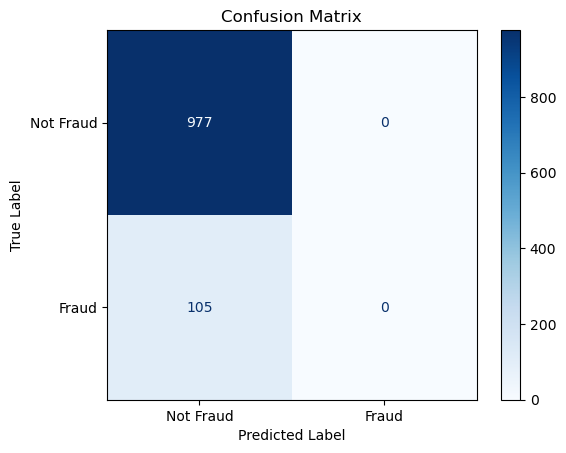

In [38]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Compute and display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

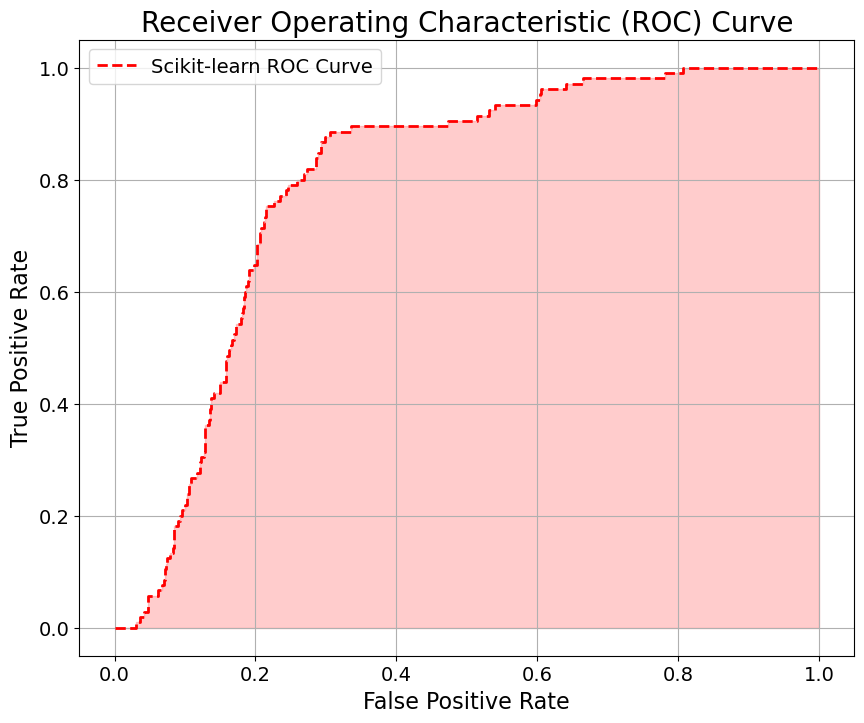

In [39]:
from sklearn.metrics import roc_curve

# Compare with scikit-learn's implementation
# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r--', lw=2, label=f'Scikit-learn ROC Curve') #(AUC = {roc_auc:.2f})')
# Fill under the ROC curve
ax.fill_between(fpr, tpr, alpha=0.2, color='red')  # alpha=0.2 makes it somewhat transparent
# Add styling with larger fonts
ax.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14)
ax.grid(True)

In [40]:
from sklearn.metrics import auc
# Area Under Curve
auc(fpr, tpr)

np.float64(0.7946093483452746)

# This park suppose to help me to fine tune the best accuracy (which is not the most important now)

In [59]:
# Perform Sequential Feature Selector with n=1 and build on above code
from sklearn.feature_selection import SequentialFeatureSelector
# I can adjust the n_features_to_select: 1, to get the best feature, 
# 2 will give me more, but unnecessary combine them will give the bset results.
sfs = SequentialFeatureSelector(model, n_features_to_select=4)
sfs.fit(X_train, y_train)

SequentialFeatureSelector(estimator=LogisticRegression(random_state=42),
                          n_features_to_select=4)

In [60]:
selected_features = X.columns[sfs.get_support()].to_list()
print(f"Features selected by SFS: {selected_features}")

Features selected by SFS: ['IPInscClaimAmtReimbursedMean', 'IPInscClaimAmtReimbursedSum', 'IPInscClaimAmtReimbursedStd', 'OPInscClaimAmtReimbursedSum']


### loooking for a better threshold to find better f1 score:

In [24]:
# Get predicted probabilities
y_proba = model.predict_proba(X_test)[:, 1]

In [25]:
precicions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

f1_scores = 2 * (precicions * recalls) / (precicions + recalls)
best_threshold = thresholds[f1_scores.argmax()]
print(f"Optimal threshold based on F1-score: {best_threshold}")

Optimal threshold based on F1-score: 0.16112487056785005


In [26]:
# apply the new best threshold to the predicted probabilities
y_pred_custom = (y_proba >= best_threshold).astype(int)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_custom)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[907  70]
 [ 30  75]]


array([0, 0, 0, ..., 0, 0, 0])

In [27]:
# Calculating metrics
accuracy = accuracy_score(y_test, y_pred_custom) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.93
Precision: 0.73
Recall: 0.41
F1 Score: 0.52


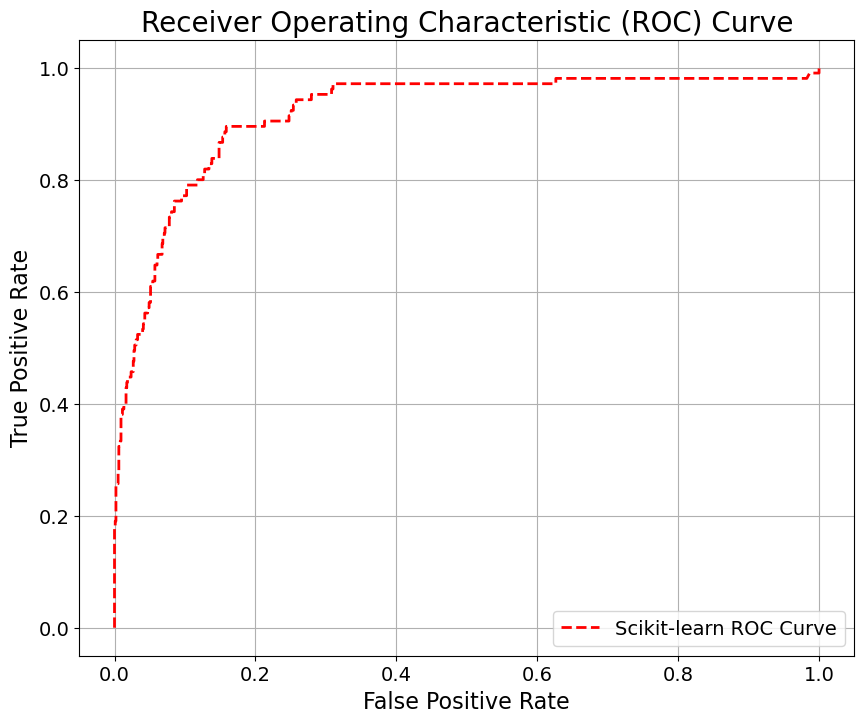

In [32]:
from sklearn.metrics import roc_curve

# Compare with scikit-learn's implementation
# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r--', lw=2, label=f'Scikit-learn ROC Curve') #(AUC = {roc_auc:.2f})')
# Add styling with larger fonts
ax.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14)
ax.grid(True)

In [33]:
from sklearn.metrics import auc
# Area Under Curve
auc(fpr, tpr)

np.float64(0.9185650923624311)

# This part is here to check only a few freaturs for the model from the ones above

In [94]:
X = final_df[['IPInscClaimAmtReimbursedMean', 
              'IPInscClaimAmtReimbursedSum', 
              'IPInscClaimAmtReimbursedStd', 
              'OPInscClaimAmtReimbursedSum']] # OP

In [95]:
y = final_df['PotentialFraud']

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)


In [97]:
# 2. Scale the features (standardization: mean = 0, std = 1).
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit on train, then transform
X_test = scaler.transform(X_test)  # Transform test data using train's mean & std


In [98]:
# 3. Train a logistic regression model.
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)  # Fit model on training data

LogisticRegression(random_state=42)

In [99]:
# 4. Make predictions on the test set.
y_predict = model.predict(X_test)  # Outputs predicted class labels (0 or 1)

y_proba = model.predict_proba(X_test)[:, 1] # Outputs predicted class labels (0 or 1)


In [100]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_predict)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[964  13]
 [ 64  41]]


In [101]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
# print('Confusion Matrix before manipulating by adding the threshold:\n')

# Calculating metrics
accuracy = accuracy_score(y_test, y_predict) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.93
Precision: 0.76
Recall: 0.39
F1 Score: 0.52


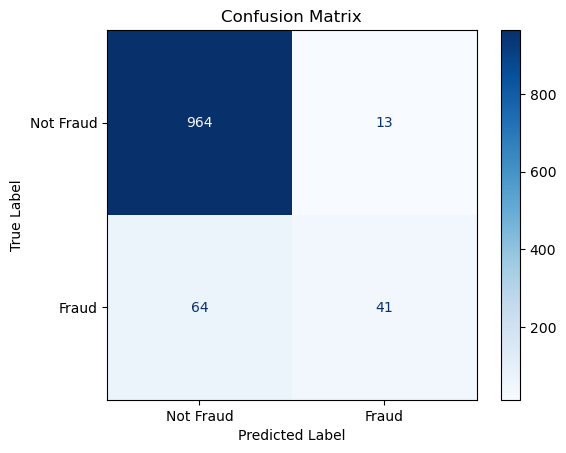

In [102]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Compute and display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

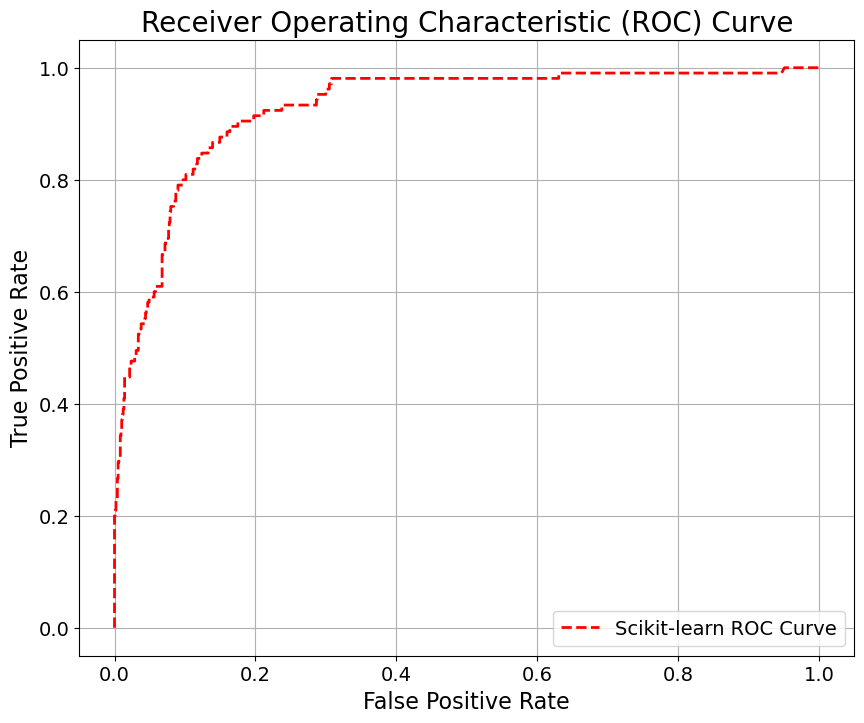

In [103]:
from sklearn.metrics import roc_curve

# Compare with scikit-learn's implementation
# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r--', lw=2, label=f'Scikit-learn ROC Curve') #(AUC = {roc_auc:.2f})')
# Add styling with larger fonts
ax.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14)
ax.grid(True)

In [104]:
from sklearn.metrics import auc
# Area Under Curve
auc(fpr, tpr)

np.float64(0.9276599892771846)